In [6]:
# Add in the neccesary libraries and depedencies
# First precompile takes more time -> Julia creates a underlying type-structure so that it can exploit the JIT feature
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
Makie.inline!(true)
include("julia_functions.jl")



minimum_cycle_basis (generic function with 1 method)

Tests for generating the appropriate action space and action space maskings

In [7]:
dimension = [2,10]
G = Graphs.smallgraph(:frucht)
tn1 = fill_with_random(G, dimension, false, false)
locs_x =     [4, 4, -5, -2, 0, 0, 2, 0, -3, -1, -6, -4]
locs_y = -1*[-2, 1, -2, -1, 0, -2, 0, 3, 3, 1, 1, 0]
g, tensordict, edgesdict, fully_weighted_edge_list, edge_index_map = extract_graph_representation(tn1, false)



(SimpleGraph{Int64}(18, [[2, 6, 7], [1, 7, 8], [4, 6, 11], [3, 5, 6], [4, 7, 10], [1, 3, 4], [1, 2, 5], [2, 9, 10], [8, 11, 12], [5, 8, 12], [3, 9, 12], [9, 10, 11]]), Dict{Int64, Tensor}(5 => [0.4055831046071253 0.7489478091008751 … 0.8779971248499582 0.0968585906764573; 0.5796298625522578 0.40444349780651556 … 0.5810136494852483 0.7719460485329285; … ; 0.44436230260624787 0.1752106859599274 … 0.9251062789465361 0.3776398242122361; 0.4116721183902916 0.5281425248542442 … 0.832420837040685 0.8866406007258147;;; 0.9987110033838623 0.17683722812159763 … 0.49702250305970486 0.5702027904900859; 0.7450907041868582 0.04185604320848102 … 0.2347519569678963 0.881933846487467; … ; 0.513236125031664 0.8393316253321081 … 0.12980780854852247 0.9828354050805171; 0.1805360562222904 0.5705977981813297 … 0.2512037525374061 0.6052923073267334;;; 0.7755655786917509 0.03483419485665307 … 0.8452685065352098 0.9246269119702727; 0.5512096294801376 0.8904398734379907 … 0.8457509075487705 0.38035679656481647;

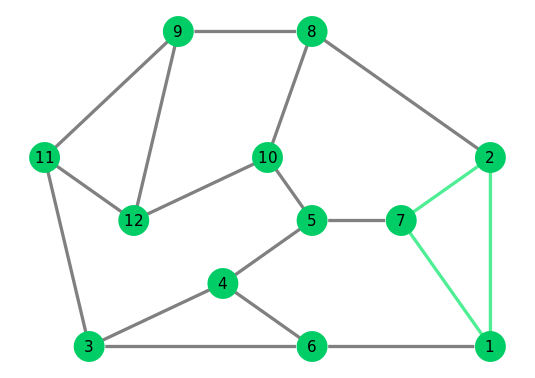

nothing

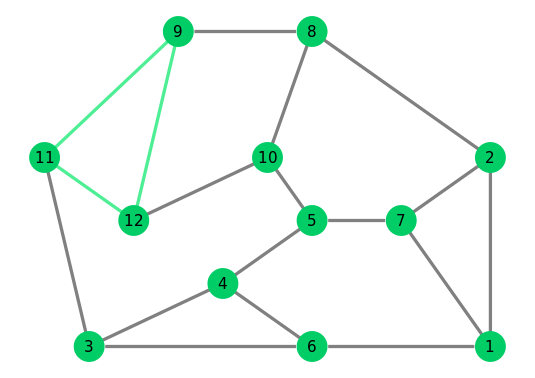

nothing

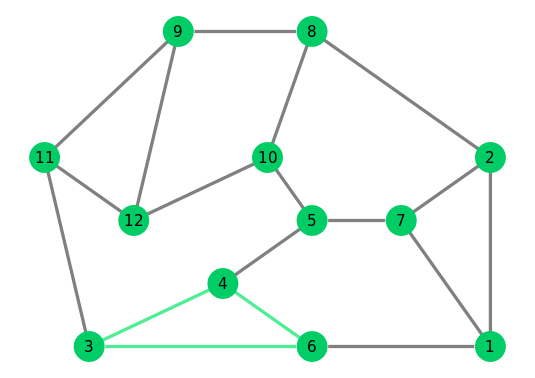

nothing

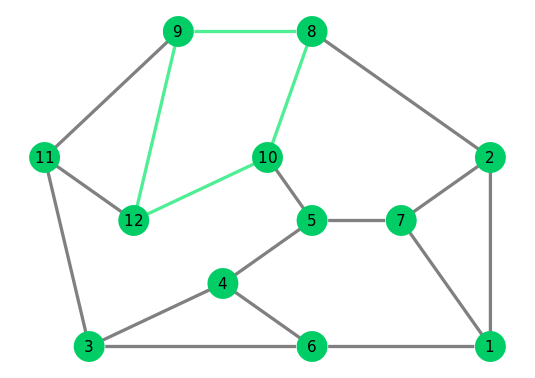

nothing

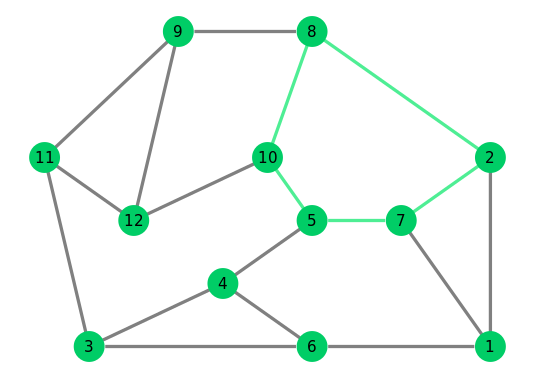

nothing

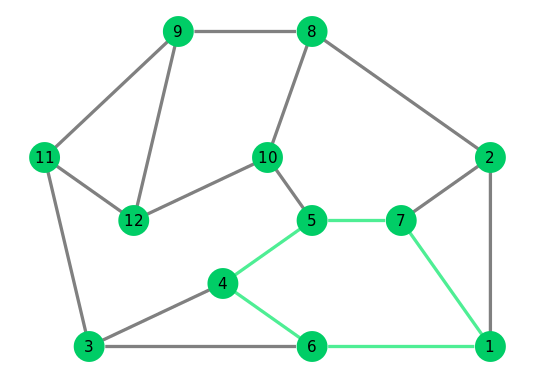

nothing

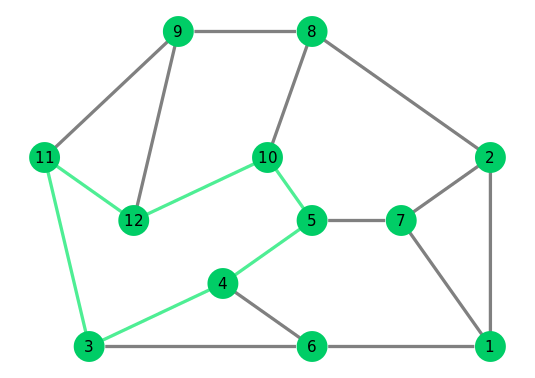

nothing

In [8]:
function minimum_cycle_basis(graph)

    """
    Return a minimum cycle basis / inner faces of a planar graph.
    This function lists all fundamental loops which are present on the graph,
    this in graph theoretical perspective comes out to finding the minimum
    cycle basis instead of a general cycle basis (of which multiple exist)
    """

    cycle_basisses = []
    
    for root in vertices(graph)
        for cycle in cycle_basis(graph, root)
            if cycle ∉ cycle_basisses
                push!(cycle_basisses, cycle)
            end
        end
    end

    unique_repr = []
    unique_faces = []
    for face in cycle_basisses
        sorted_face = Tuple(sort(face))
        if !(sorted_face in unique_repr)
            push!(unique_repr, sorted_face)
            push!(unique_faces, face)
        end
    end

    # Sort lists by their lengths
    sorted_faces = sort(unique_faces, by=length)

    # Select the smallest possible elements forming a cycle basis
    smallest_loops = sorted_faces[1:length(cycle_basis(graph))]
    return smallest_loops
end

# This function correctly extracts all the inner faces on the planar graph g
faces = minimum_cycle_basis(g)
for face in faces
    display(display_selected_cycle(g, face))
end




Now onto the creation of the action matrix:

Combination of action which is selecting a loop and a edge within a loop

In [14]:
function create_actionmatrix(graph)

    """
    Function which takes in a graphs.jl graphs object and which generates the
    possible actions in a matrix format. Here the collums represent possible 
    edges and here the rows identify with the different possible faces. 
    This way selecting a element of action matrix A[i,j] corresponds to
    selecting both a possible face and an edge on the circumfrence of the face.
    """

    faces = minimum_cycle_basis(graph)
    edges_graph = cycle_basis_to_edges(faces)
    edge_basis = cyclebasis_to_edgebasis(faces)

    # Create an action matrix with dimensions of #cycles ₓ #edges
    A = zeros(Int, length(edge_basis), length(edges_graph))
        
    # Iterate through each cycle and check if each edge is inside
    for (i, edgegroup) in enumerate(edge_basis)
        for (j, edge) in enumerate(edges_graph)
            if any(c == edge for c in edgegroup)
                A[i, j] = 1
            end
        end
    end
    display(edge_basis)
    println((edges_graph))
    display(A)
end

function cyclebasis_to_edgebasis(minimal_cyclebasis)

    """
    Helper function for generating the possible edges inside of cycle,
    this allows to easily generate the action matrix.
    """
    
    edge_basis = []

    for cycle in minimal_cyclebasis
        # extract the edges from the current cycle
        c_edges = [Tuple(sort([cycle[i], cycle[i+1]])) for i in 1:length(cycle)-1]
        push!(c_edges, Tuple(sort([cycle[end], cycle[1]])))
        push!(edge_basis, c_edges)
    end
    return edge_basis
end




    
create_actionmatrix(g)






7-element Vector{Any}:
 [(2, 7), (1, 7), (1, 2)]
 [(9, 11), (11, 12), (9, 12)]
 [(4, 6), (3, 6), (3, 4)]
 [(8, 9), (9, 12), (10, 12), (8, 10)]
 [(2, 8), (8, 10), (5, 10), (5, 7), (2, 7)]
 [(4, 6), (4, 5), (5, 7), (1, 7), (1, 6)]
 [(3, 4), (3, 11), (11, 12), (10, 12), (5, 10), (4, 5)]

7×18 Matrix{Int64}:
 1  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  1
 0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  1  1  0
 0  0  0  1  1  0  0  0  0  0  1  1  0  1  0  0  0  0
 0  1  1  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  1  1  0  0  1  0  0  0  0  1  1

Any[(1, 2), (1, 6), (1, 7), (2, 7), (2, 8), (3, 4), (3, 6), (3, 11), (4, 5), (4, 6), (5, 7), (5, 10), (8, 9), (8, 10), (9, 11), (9, 12), (10, 12), (11, 12)]
